# Notes

# Setup

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets

plt.rcParams["figure.figsize"] = (12, 4)

# Data

In [11]:
stocks = pd.read_csv("../data/all_stocks_5yr.csv.gz", parse_dates=["date"])
stocks

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [12]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [13]:
stocks = stocks.set_index("date").groupby("Name").resample("W").mean().reset_index()
stocks

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070000,45.350000,45.000000,45.080000,1824755.00
1,A,2013-02-17,44.598000,44.878000,44.040000,44.160000,5165006.80
2,A,2013-02-24,42.255000,42.545000,41.871250,42.170000,3689833.75
3,A,2013-03-03,41.332000,41.891000,40.898000,41.480000,3985236.20
4,A,2013-03-10,42.780000,43.178000,42.518000,42.842000,2878377.80
...,...,...,...,...,...,...,...
128835,ZTS,2018-01-14,74.334000,75.013000,73.879140,74.648000,2431182.00
128836,ZTS,2018-01-21,76.302500,76.747500,75.667500,76.315000,3196819.50
128837,ZTS,2018-01-28,78.018000,78.784000,77.783000,78.548000,2780926.20
128838,ZTS,2018-02-04,78.222000,78.760000,77.396000,77.772000,3236979.20


# Sandbox

In [62]:
from tstools.forecast.models import (
    Naive,
    Drift,
    Mean,
    ETS,
    ARIMA,
    AutoARIMA,
    AutoRegression,
    ScikitRegression,
    VAR,
)
from tstools.metrics import mae, mse

from darts.timeseries import TimeSeries
from darts.models import ( 
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA as arima_darts,
    AutoARIMA as autoarima_darts,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)
import darts.metrics
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm

from warnings import filterwarnings
filterwarnings('ignore')

In [15]:
#data = stocks[stocks.Name.isin(["A", "AAL"])]
data = stocks[stocks.Name.isin(["A"])]
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [16]:
train = data.iloc[:-10].copy()
test = data.iloc[-10:].copy()

In [17]:
ts_train = TimeSeries.from_dataframe(train[["date", "open"]].set_index("date"))
ts_test = TimeSeries.from_dataframe(test[["date", "open"]].set_index("date"))
cov_train = TimeSeries.from_dataframe(train[["date", "close"]].set_index("date"))
cov_test = TimeSeries.from_dataframe(test[["date", "close"]].set_index("date"))

In [18]:
ts_train_endog = train.set_index("date").asfreq("W")["open"].copy()
ts_train_exog = train.set_index("date").asfreq("W")["close"].copy()
ts_test_endog = test.set_index("date").asfreq("W")["open"].copy()
ts_test_exog = test.set_index("date").asfreq("W")["close"].copy()

In [107]:
train

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.0700,45.350,45.00000,45.080,1824755.00
1,A,2013-02-17,44.5980,44.878,44.04000,44.160,5165006.80
2,A,2013-02-24,42.2550,42.545,41.87125,42.170,3689833.75
3,A,2013-03-03,41.3320,41.891,40.89800,41.480,3985236.20
4,A,2013-03-10,42.7800,43.178,42.51800,42.842,2878377.80
...,...,...,...,...,...,...,...
247,A,2017-11-05,67.9820,68.318,67.66000,68.008,1349637.60
248,A,2017-11-12,68.3660,68.578,67.95220,68.272,1206826.00
249,A,2017-11-19,67.3500,68.158,67.15800,67.886,2025692.20
250,A,2017-11-26,69.3275,69.950,68.43250,69.480,3382786.50


In [274]:
#model = Naive(time_col="date", target_cols=["open"], regressor_cols=None, freq="W")
#model = Drift(time_col="date", target_cols="open", regressor_cols=None, freq=None)
#model = Mean(time_col="date", target_cols="open", regressor_cols=None, freq=None)
model = ARIMA(time_col="date", target_cols=["open"], regressor_cols=["close"], freq=None, order=(5, 1, 0))
#model = ETS(time_col="date", target_cols=["open"], regressor_cols=None, freq=None, trend="add", damped_trend=True)
#model = AutoRegression(time_col="date", target_cols="open", regressor_cols=None, freq=None, lags=5, trend="n")
#model = AutoARIMA(time_col="date", target_cols="open", regressor_cols=None, freq="W")
#model = VAR(time_col="date", target_cols=["open", "volume"], regressor_cols=["close"])
#model_alt = ARIMAm(time_col="date", target_cols=["open"], regressor_cols=None, order=(5, 1, 0))

In [276]:
#model_darts = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.NONE)
model_darts = arima_darts(p=5, d=1, q=0)
#model_darts = NaiveSeasonal()

In [277]:
model.fit(train)

ARIMA(time_col='date', freq='W-SUN', target_cols=['open'], regressor_cols=['close'], order=(5, 1, 0), seasonal_order=(0, 0, 0, 0), trend=None, arima_params={}, fit_params={})

In [279]:
model_darts.fit(ts_train, cov_train)

In [280]:
future = model.get_future_dataframe(train, fh=10)
future = future.merge(data[["date", "close"]], on="date")
fcst = model.predict(future, conf_int=0.95)
fcst

,date,close,open_fcst,open_lower,open_upper
0,2017-12-10,66.410000,66.389643,65.903553,66.875734
1,2017-12-17,66.972000,66.869279,66.377460,67.361097
2,2017-12-24,67.536000,67.429043,66.927294,67.930792
3,2017-12-31,67.242500,67.153639,66.644452,67.662826
4,2018-01-07,68.905000,68.859083,68.325687,69.392478
5,2018-01-14,71.028000,70.976738,70.422815,71.530662
6,2018-01-21,72.137500,72.049853,71.471540,72.628165
7,2018-01-28,73.836000,73.736014,73.145531,74.326496
8,2018-02-04,73.006000,72.917090,72.311832,73.522348
9,2018-02-11,68.243333,68.179358,67.558959,68.799758


In [282]:
ts_fcst = model_darts.predict(10, cov_test)
fcst_darts = ts_fcst.pd_dataframe()
fcst_darts.columns.name = None
fcst_darts.reset_index()

,time,open
0,2017-12-10,66.389643
1,2017-12-17,66.869279
2,2017-12-24,67.429043
3,2017-12-31,67.153639
4,2018-01-07,68.859083
5,2018-01-14,70.976738
6,2018-01-21,72.049853
7,2018-01-28,73.736014
8,2018-02-04,72.917090
9,2018-02-11,68.179358


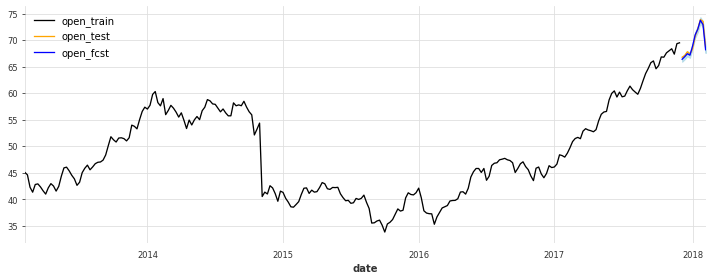

In [283]:
model.plot_fcst(fcst, train=None, test=test, plot_history=True, figsize=(10, 4), style="-")          

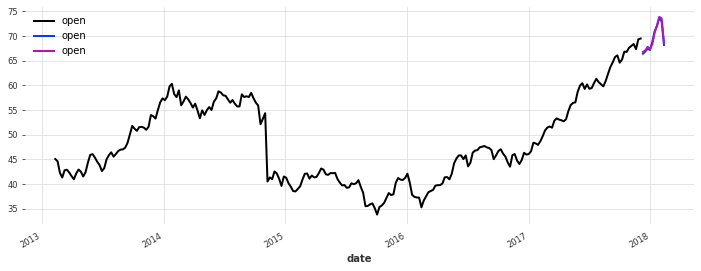

In [284]:
ts_train.plot()
ts_fcst.plot()
ts_test.plot()

In [285]:
model.score(fcst, test, metrics=[mae, mse])

,open
mae,0.331440
mse,0.140283


In [286]:
hfcst = model.historical_forecasts(train, fh=10)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:14<00:00,  7.81it/s]


In [287]:
hfcst[0]

,date,close,open_fcst
0,2015-07-12,39.2440,39.353264
1,2015-07-19,40.1740,40.301647
2,2015-07-26,39.9040,39.970634
3,2015-08-02,40.4760,40.564520
4,2015-08-09,40.4900,40.545253
5,2015-08-16,39.1980,39.307134
6,2015-08-23,37.9960,38.084710
7,2015-08-30,35.5620,35.663205
8,2015-09-06,35.4800,35.565275
9,2015-09-13,35.8925,35.986455


In [289]:
hfcst_darts = model_darts.historical_forecasts(ts_train, future_covariates=cov_train, forecast_horizon=10, last_points_only=False, verbose=True, overlap_end=False)
hfcst_darts = [fcst.pd_dataframe() for fcst in hfcst_darts]
hfcst_darts = hfcst_darts[1:]

  0%|          | 0/118 [00:00<?, ?it/s]

In [290]:
hfcst_darts[0]

component,open
time,
2015-07-12,39.353264
2015-07-19,40.301647
2015-07-26,39.970634
2015-08-02,40.564520
2015-08-09,40.545253
2015-08-16,39.307134
2015-08-23,38.084710
2015-08-30,35.663205
2015-09-06,35.565275


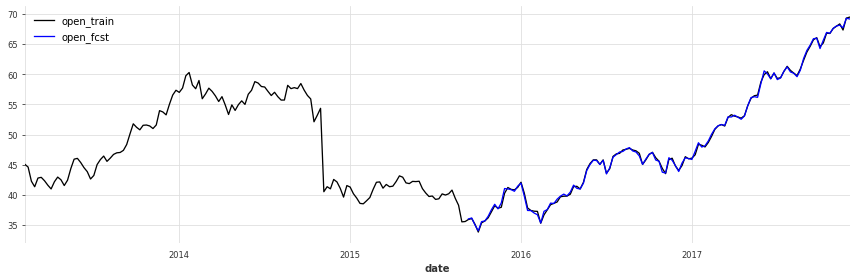

In [291]:
hfcst_tail = pd.concat([fcst.tail(1) for fcst in hfcst]).reset_index(drop=True)
model.plot_fcst(hfcst_tail, train=train)

<AxesSubplot:xlabel='time'>

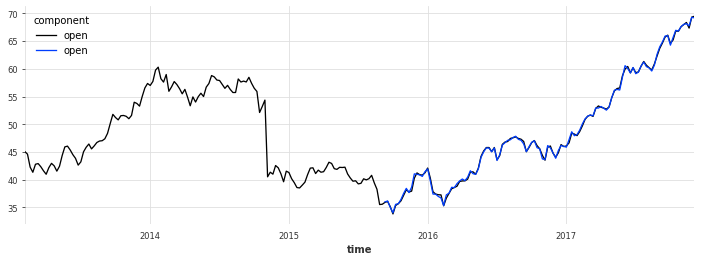

In [292]:
hfcst_darts_tail = pd.concat([fcst.tail(1) for fcst in hfcst_darts])

f, ax = plt.subplots()
ts_train.pd_dataframe().plot(ax=ax)
hfcst_darts_tail.plot(ax=ax)

In [293]:
model.score_cv(hfcst, train, metrics=[mae, mse])

open          
          mae       mse
0    0.133440  0.030678
1    0.139820  0.031481
2    0.134987  0.029101
3    0.151980  0.032801
4    0.167096  0.038140
..        ...       ...
112  0.177197  0.048372
113  0.179690  0.042589
114  0.224494  0.063290
115  0.231462  0.067719
116  0.220129  0.065394

[117 rows x 2 columns]

In [296]:
score_darts = model_darts.backtest(ts_train, future_covariates=cov_train, forecast_horizon=10, last_points_only=False, verbose=True, overlap_end=False, metric=darts.metrics.mae, reduction=None)
score_darts = score_darts[1:]
score_darts[:5]

  0%|          | 0/118 [00:00<?, ?it/s]

[0.13344039241863684,
 0.1398199898839998,
 0.1349872779501709,
 0.1519800327234087,
 0.16709557049386348]

In [297]:
model.score_cv(hfcst, train, metrics=[mae, mse], agg=np.mean)

,open
mae,0.195697
mse,0.065715


In [298]:
np.mean(score_darts)

0.19569667097563195